<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: El Nino spectrum and significance testing</h1>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Is there a significant spectral peak? 
--------

In [ ]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal

In [191]:
!ls *.nc  # show files in directory

q=Dataset('iersst_nino3.4a.nc','r',format='NETCDF4')  
#q.variables 

iersst_nino3.4a.nc           iersst_nino3.4a_noise_000.nc iersst_nino3.4a_noise_001.nc


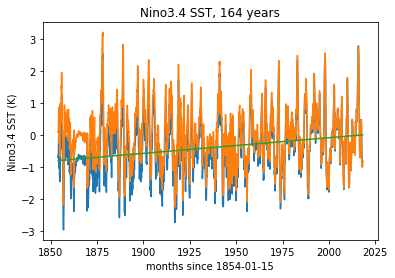

In [192]:
# Import and cleanup data for KNMI series 
t = np.array(q.variables['time'])   #time
R = np.array(q.variables['Nino3.4'])#SST 

R[R==3e+33]=np.nan                  #Remove nans
t = t[~np.isnan(R)]
R = R[~np.isnan(R)]

# Convert months to years 
NYEAR = len(R)/12.
yyyy = 1854 + t/12
SST = R

plt.plot(yyyy,SST)
plt.xlabel('months since 1854-01-15');plt.ylabel('Nino3.4 SST (K)')
plt.title('Nino3.4 SST, '+str(int(NYEAR))+' years')

plt.plot(yyyy,signal.detrend(SST))

plt.plot(yyyy,SST-signal.detrend(SST))

----------------
<a name="spectrum"></a>
### Is there a "significant" periodicity to ENSO?

Let's look at the power spectrum

Variance is 0.8029766 K^2: matches 0.8029766082763673
Detrended variance is 0.7492293 K^2: matches 0.7492293119430539


Text(0.5,1,'Periodogram after detrending')

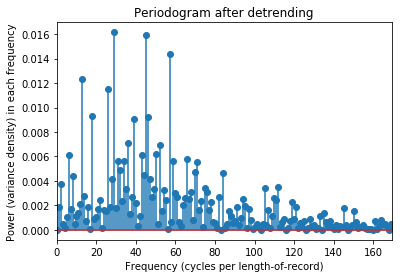

In [193]:
NT = len(R)

# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)
freqs = np.array(range(NT))   # This gets the left end correct
reversed_freqs = freqs[::-1]  # Reverse the array 
reversed_freqs[0:int(NT/2)] = -freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
freqs = reversed_freqs[::-1]  # reverse it back 


# Variable V for the spectrum code
V = SST

# Remove the mean, detrend
Vp = V - V.mean()
Vd = signal.detrend(Vp)
Vd = Vd - Vd.mean()

# Spectrum
Vspec = np.fft.fft( Vp )
Power = (Vspec.conjugate()*Vspec).real
Power *= np.var(Vp) / Power.sum()       # Enforce Parseval's theorem for variance 
print('Variance is', Vp.var(), 'K^2: matches', sum(Power))

# Detrended spectrum 
Vdspec = np.fft.fft( Vd )
Powerd = (Vdspec.conjugate()*Vdspec).real
Powerd *= np.var(Vd) / Powerd.sum()       # Enforce Parseval's theorem for variance 
print('Detrended variance is', Vd.var(), 'K^2: matches', sum(Powerd))

# Plot
fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Powerd)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('Periodogram after detrending')

## What was the detrending effect?

Text(0.5,1,'Periodogram difference due to detrending')

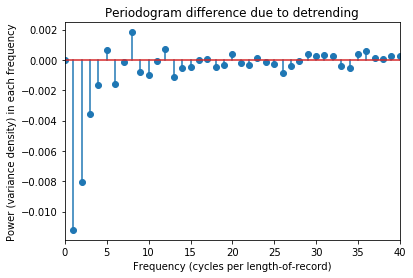

In [102]:
fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Powerd-Power)

ax.set_xlim([0,40])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('Periodogram difference due to detrending')

## Want more degrees of freedom per band? Rebin the spectrum

Text(0.5,1,'Periodogram rebinned by factor of 5')

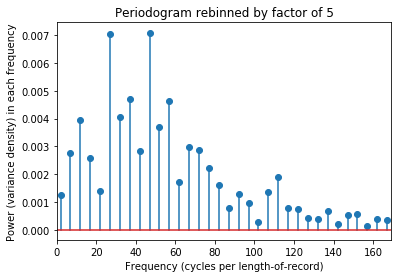

In [101]:
Pd5 = Powerd.reshape(int(NT/5),5).mean(1)
f5 = freqs.reshape(int(NT/5),5).mean(1)

fig,ax=plt.subplots(1,1) 
ax.stem(f5, Pd5)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('Periodogram rebinned by factor of 5')

Text(0.5,1,'Periodogram rebinned by factor of 10')

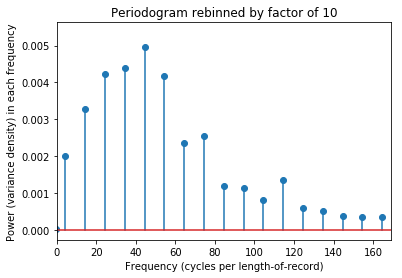

In [145]:
Pd10 = Powerd.reshape(int(NT/10),10).mean(1)
f10 = freqs.reshape(int(NT/10),10).mean(1) 

fig,ax=plt.subplots(1,1) 
ax.stem(f10, Pd10)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('Periodogram rebinned by factor of 10')

## Would that peak be hidden if we forgot to detrend?

Text(0.5,1,'Non-detrended (rebin factor 10)')

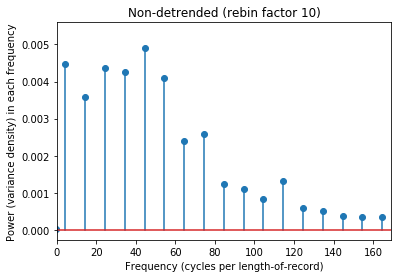

In [147]:
P10 = Power.reshape(int(NT/10),10).mean(1)
f10 = freqs.reshape(int(NT/10),10).mean(1) 

fig,ax=plt.subplots(1,1) 
ax.stem(f10, P10)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('Non-detrended (rebin factor 10)')

------------

<a name='AR1'></a>
# Autoregression as a model for geophysical noise

# Postulate an "explanation" of SST by prior SST
$SST_t = intercept + c \cdot SST_{t-1} + residual_t$

Text(0.5,1,'SST and prior month SST')

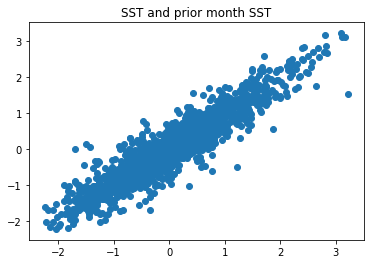

In [136]:
SST = signal.detrend(SST)
SST_1 = np.roll(SST,-1) # same data rolled back one month

fig,ax = plt.subplots(1,1)

ax.scatter(SST, SST_1)
ax.set_title('SST and prior month SST')

In [137]:
import scipy, scipy.stats

slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(SST,SST_1)
    
Prediction = intercept + slope*SST_1
print( slope, intercept )
print("r-squared:", r_value**2)

0.930476059506326 8.299249561428582e-11
r-squared: 0.8657856973144198


In [138]:
resid = SST - Prediction

Text(0.5,1,'SST and residual of AR1 prediction')

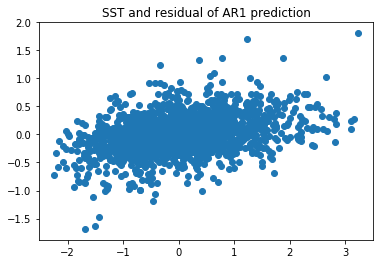

In [139]:
fig,ax = plt.subplots(1,1)

ax.scatter(SST, resid)
ax.set_title('SST and residual of AR1 prediction')

## Not a bad fit -- the residual has little relationship
### So we can model the residual with random noise 

In [142]:
sigma = np.std(resid)
FAKE_resid = np.random.randn( len(SST) )*sigma

# Make some fake data
FAKE = SST*0 + np.mean(SST) # right shaped container, mean value

for i in 1+np.arange(len(SST)-1): 
    FAKE[i] = intercept + slope*FAKE[i-1] + np.random.randn()*sigma

Text(0.5,1,'SST and AR1 noise')

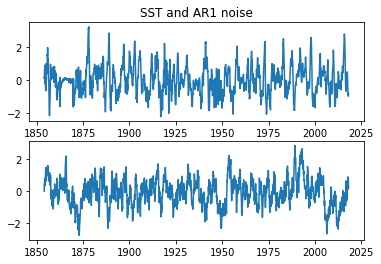

In [143]:
fig,ax =plt.subplots(2,1)
ax[0].plot(yyyy, signal.detrend(SST))
ax[1].plot(yyyy, FAKE)
ax[0].set_title('SST and AR1 noise')

## Let's see the spectrum of the AR1 fake data

In [148]:
# Variable V for the spectrum code
V = FAKE

# Remove the mean, detrend
Vd = signal.detrend(V)
Vd = Vd - Vd.mean()

# Spectrum
Vspec = np.fft.fft( Vd )
Power = (Vspec.conjugate()*Vspec).real
Power *= np.var(Vd) / Power.sum()       # Enforce Parseval's theorem for variance 

Text(0.5,1,'NINO3.4 and AR1 spectrum')

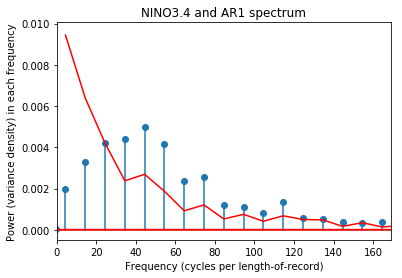

In [166]:
P10 = Power.reshape(int(NT/10),10).mean(1)
P5 = Power.reshape(int(NT/5),5).mean(1)

fig,ax=plt.subplots(1,1) 
ax.stem(f10, Pd10)
#ax.stem(f5, Pd5)

# Detrended Pd10 and rebinned AR1: a comparative view 
ax.plot(f10, P10, 'r')

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('NINO3.4 and AR1 spectrum')

Text(0.5,1,'Variance ratio: for F test')

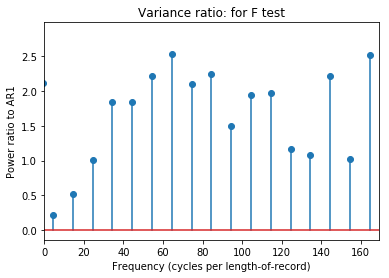

In [168]:
## Plot the ratio, for the F test 

fig,ax=plt.subplots(1,1) 
ax.stem(f10, Pd10/P10)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power ratio to AR1')
ax.set_title('Variance ratio: for F test')


## Need a less noisy AR1 spectrum: more instances

<Container object of 3 artists>

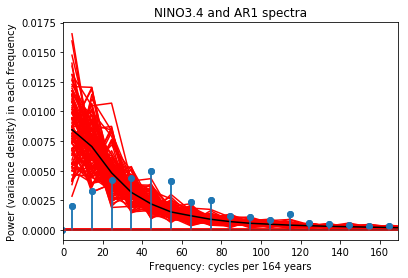

In [189]:
fig,ax=plt.subplots(1,1) 
ax.stem(f10, Pd10)
ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency: cycles per '+str(int(NYEAR))+' years')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('NINO3.4 and AR1 spectra')

# Make MORE fake data
P10sum = P10 # sum up 100 values

for ifake in range(1, 100):
    FAKE = SST*0 + np.mean(SST) # right shaped container, mean value
    for i in 1+np.arange(len(SST)-1): 
        FAKE[i] = intercept + slope*FAKE[i-1] + np.random.randn()*sigma
    
    V = FAKE
    Vd = signal.detrend(V)
    Vd = Vd - Vd.mean()

    # Spectrum
    Vspec = np.fft.fft( Vd )
    Power = (Vspec.conjugate()*Vspec).real
    Power *= np.var(Vd) / Power.sum()
    P10 = Power.reshape(int(NT/10),10).mean(1)
    P10sum += P10
    ax.plot(f10, P10, 'r')

P10red = P10sum/101
ax.plot(f10, P10red, 'k')
ax.stem(f10, Pd10)

Text(0.5,1,'Variance ratio: for F test')

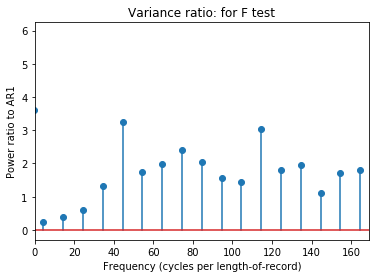

In [186]:
## Plot the ratio, for the F test 

fig,ax=plt.subplots(1,1) 
ax.stem(f10, Pd10/P10)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power ratio to AR1')
ax.set_title('Variance ratio: for F test')


https://en.wikipedia.org/wiki/F-test

## What if we didn't rebin frequency bands? 
### 2 DOF per frequency band instead of 20

<Container object of 3 artists>

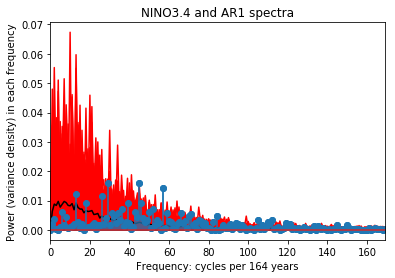

In [195]:
## How about raw? 
fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Powerd)
ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency: cycles per '+str(int(NYEAR))+' years')
ax.set_ylabel('Power (variance density) in each frequency')
ax.set_title('NINO3.4 and AR1 spectra')

# Make MORE fake data
Psum = Power # sum up 100 values

for ifake in range(1, 100):
    FAKE = SST*0 + np.mean(SST) # right shaped container, mean value
    for i in 1+np.arange(len(SST)-1): 
        FAKE[i] = intercept + slope*FAKE[i-1] + np.random.randn()*sigma
    
    V = FAKE
    Vd = signal.detrend(V)
    Vd = Vd - Vd.mean()

    # Spectrum
    Vspec = np.fft.fft( Vd )
    Power = (Vspec.conjugate()*Vspec).real
    Power *= np.var(Vd) / Power.sum()
    Psum += Power
    ax.plot(freqs, Power, 'r')

Pred = Psum/101
ax.plot(freqs, Pred, 'k')
ax.stem(freqs, Powerd)

Text(0.5,1,'Variance ratio: for F test')

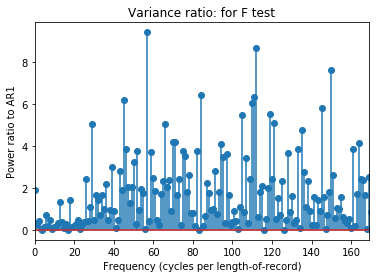

In [197]:
## Plot the ratio, for the F test 

fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Powerd/Pred)

ax.set_xlim([0,NYEAR+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power ratio to AR1')
ax.set_title('Variance ratio: for F test')
